In [1]:
# import 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.utils import resample

import warnings
warnings.filterwarnings('ignore')

In [12]:
# read file

df = pd.read_csv('forestfires.csv')
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [4]:
df.info() # no NaN values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [5]:
df.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


## What is the distribution of fire areas across different months?

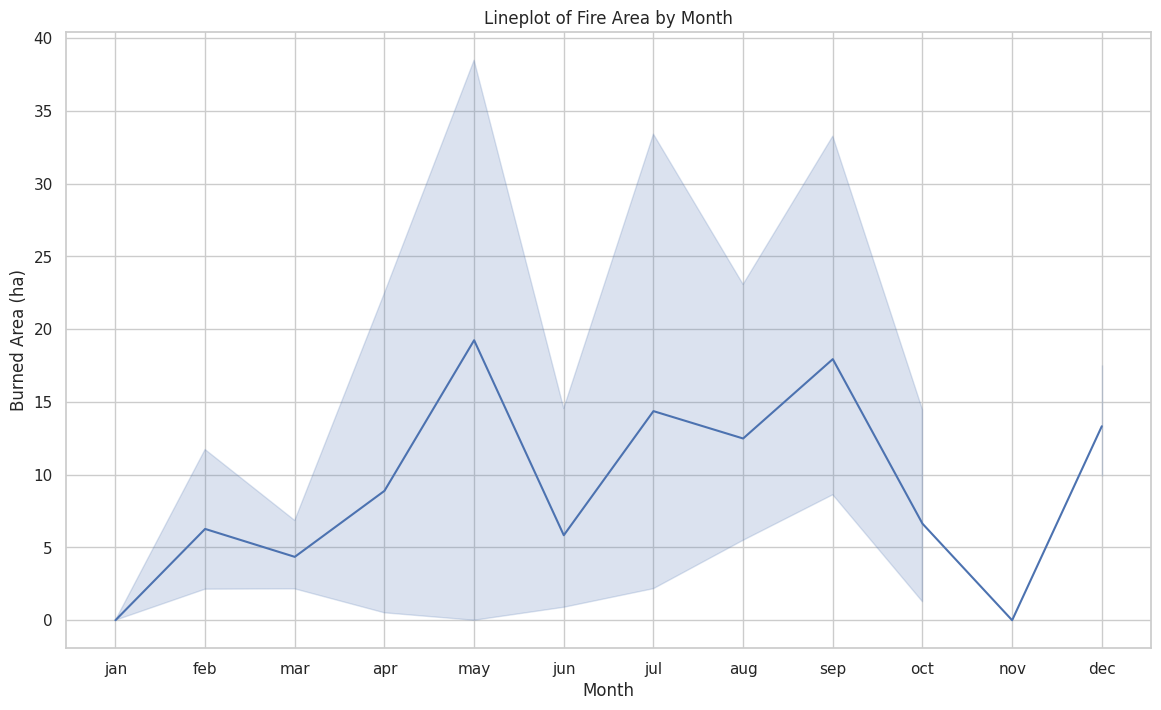

In [59]:
# set month order
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# set 'month' as categoricals with order
df['month'] = pd.Categorical(df['month'], categories=month_order, ordered=True)

# lineplot
plt.figure(figsize=(14, 8))
sns.lineplot(x='month', y='area', data=df, palette='tab10')
plt.title('Lineplot of Fire Area by Month')
plt.xlabel('Month')
plt.ylabel('Burned Area (ha)')
plt.show()

## How does fire frequency and area distribution vary by geographical location?

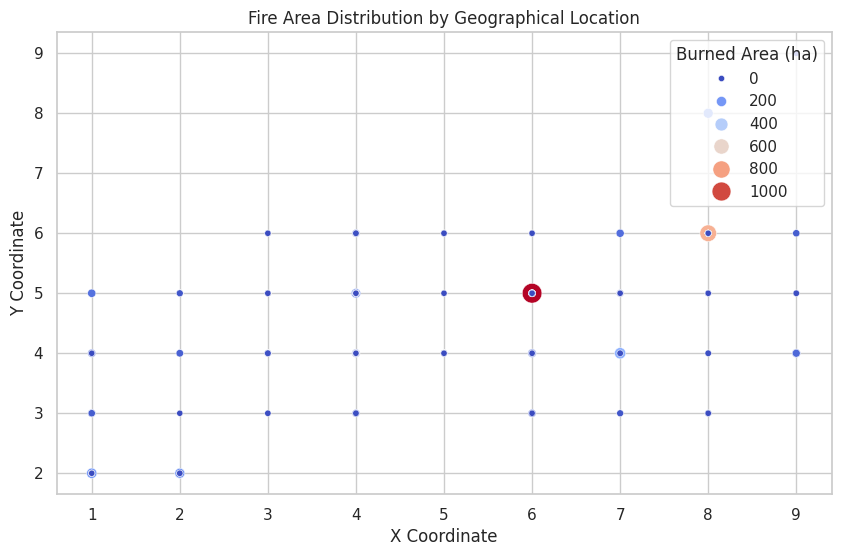

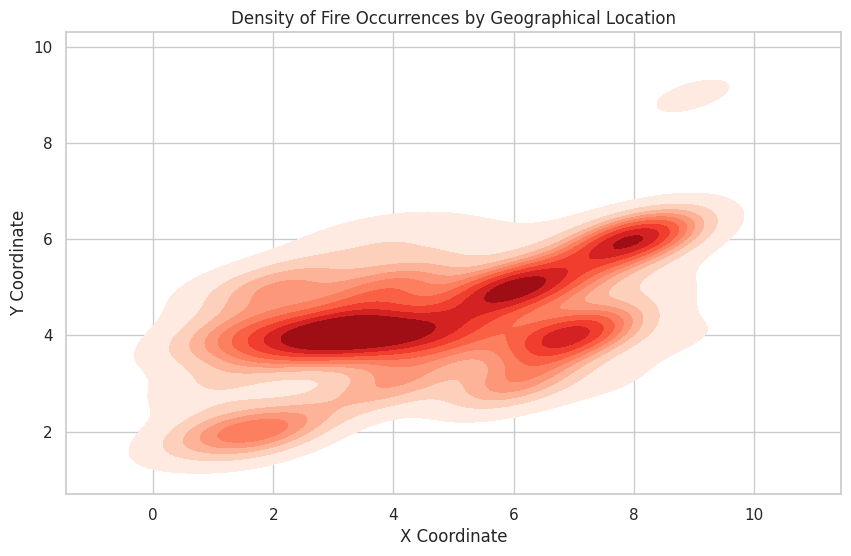

In [60]:
# scatter plot 
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['X'], y=df['Y'], size=df['area'], hue=df['area'], palette='coolwarm', sizes=(20, 200))
plt.title('Fire Area Distribution by Geographical Location')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend(title='Burned Area (ha)', loc='upper right')
plt.show()

# kdeplot 
plt.figure(figsize=(10, 6))
sns.kdeplot(x=df['X'], y=df['Y'], fill=True, cmap='Reds')
plt.title('Density of Fire Occurrences by Geographical Location')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

## What is the relationship between temperature (temp) and fire area?

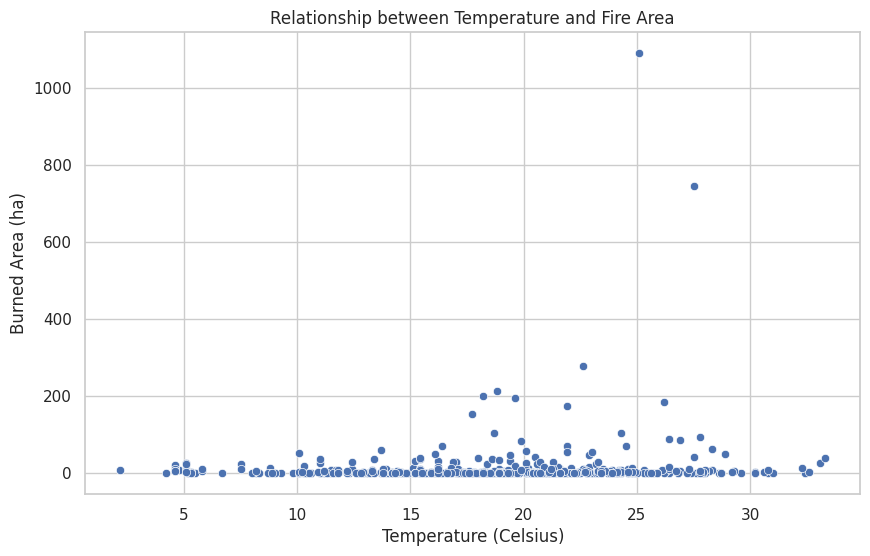

Correlation between Temperature and Fire Area: 0.10


In [61]:
# scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['temp'], y=df['area'])
plt.title('Relationship between Temperature and Fire Area')
plt.xlabel('Temperature (Celsius)')
plt.ylabel('Burned Area (ha)')
plt.show()

# calculate correation coefficients
correlation_temp_area = df['temp'].corr(df['area'])
print(f"Correlation between Temperature and Fire Area: {correlation_temp_area:.2f}")

## Is there a statistically significant difference in fire area between months with higher temperatures (e.g., summer months) and lower temperatures (e.g., winter months)?

In [64]:
'''
H0 (Null Hypothesis): There is no difference in the average fire area between high-temperature months and low-temperature months.
H1 (Alternative Hypothesis): There is a difference in the average fire area between high-temperature months and low-temperature months.
'''

# divide moths into 2 groups
high_temp_months = ['jun', 'jul', 'aug']
low_temp_months = ['dec', 'jan', 'feb']

high_temp_data = df[df['month'].isin(high_temp_months)]['area']
low_temp_data = df[df['month'].isin(low_temp_months)]['area']

# check nomality
from scipy.stats import shapiro 

stat_high, p_high = shapiro(high_temp_data)
stat_low, p_low = shapiro(low_temp_data)

# decide which test method
from scipy.stats import ttest_ind, mannwhitneyu

if p_high > 0.05 and p_low > 0.05:
    stat, p_value = ttest_ind(high_temp_data, low_temp_data)
    test_used = 'Independent t-test'
else:
    stat, p_value = mannwhitneyu(high_temp_data, low_temp_data)
    test_used = 'Mann-Whitney U test'

print(f"{test_used}: p-value = {p_value:.3f}")

Mann-Whitney U test: p-value = 0.076


In [65]:
from scipy.stats import mannwhitneyu

# Mann-Whitney U 
stat, p_value = mannwhitneyu(high_temp_data, low_temp_data)

alpha = 0.05

if p_value < alpha:
    print("Reject Null Hypothesis: There is a significant difference in fire areas between high temperature and low temperature months.")
else:
    print("Fail to reject Null Hypothesis: There is no significant difference in fire areas between high temperature and low temperature months.")

Fail to reject Null Hypothesis: There is no significant difference in fire areas between high temperature and low temperature months.


## Does wind speed (wind) significantly affect the size of the fire area?

In [66]:
'''
Null Hypothesis: Wind speed has no effect on the size of the fire area.
Alternative Hypothesis: Wind speed has a significant effect on the size of the fire area.
'''
import statsmodels.api as sm

X = df['wind']  
y = df['area']  

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   area   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.07815
Date:                Tue, 13 Aug 2024   Prob (F-statistic):              0.780
Time:                        13:23:14   Log-Likelihood:                -2880.4
No. Observations:                 517   AIC:                             5765.
Df Residuals:                     515   BIC:                             5773.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0891      6.885      1.611      0.108      -2.438      24.616
wind           0.4376      1.565      0.280      0.780      -2.638       3.513
==============================================================================
Omnibus:                      983.721   Durbin-Watson:                   1.647
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           810324.708
Skew:                          12.809   Prob(JB):                         0.00
Kurtosis:                     195.251   Cond. No.                         11.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# Based on the 0 r2, decide to check the distribution for outliers.

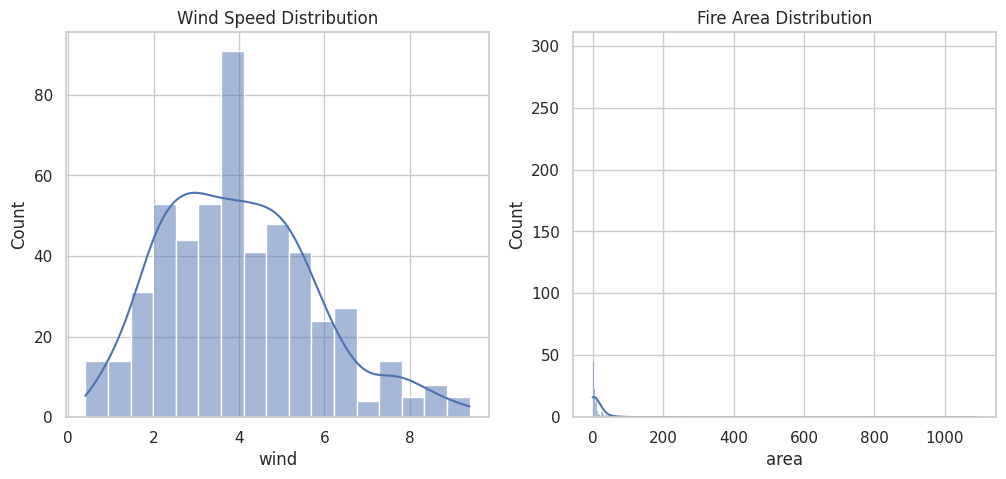

In [68]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['wind'], kde=True)
plt.title('Wind Speed Distribution')

plt.subplot(1, 2, 2)
sns.histplot(df['area'], kde=True)
plt.title('Fire Area Distribution')

plt.show()

In [69]:
# log transfer for area
df['log_area'] = np.log1p(df['area'])

X = sm.add_constant(df['wind'])
model = sm.OLS(df['log_area'], X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               log_area   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.320
Date:                Tue, 13 Aug 2024   Prob (F-statistic):              0.128
Time:                        13:26:31   Log-Likelihood:                -905.31
No. Observations:                 517   AIC:                             1815.
Df Residuals:                     515   BIC:                             1823.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9010      0.151      5.969      0.0

In [ ]:
'''
The linear regression analysis showed that wind speed's impact on fire area is not statistically significant, with an R² value of only 0.004. 
However, this poor model fit suggests that linear regression may not be the best method to capture the relationship between these variables. 
Future research will explore alternative approaches to better understand the factors influencing fire area size.
'''

## Is there a significant correlation between relative humidity (RH) and fire area?

In [70]:
'''
Null Hypothesis: There is no correlation between relative humidity and fire area.
Alternative Hypothesis: There is a significant correlation between relative humidity and fire area.
'''
# check normality
stat_rh, p_rh = shapiro(df['RH'])
stat_area, p_area = shapiro(df['area'])

from scipy.stats import pearsonr, spearmanr

if p_rh > 0.05 and p_area > 0.05:
    corr, p_value = pearsonr(df['RH'], df['area'])
    test_used = "Pearson's correlation"
else:
    corr, p_value = spearmanr(df['RH'], df['area'])
    test_used = "Spearman's rank correlation"

print(f"{test_used}: correlation coefficient = {corr:.3f}, p-value = {p_value:.3f}")

# evaluate
alpha = 0.05

if p_value < alpha:
    print("Reject Null Hypothesis: There is a significant correlation between RH and fire area.")
else:
    print("Fail to reject Null Hypothesis: There is no significant correlation between RH and fire area.")

Spearman's rank correlation: correlation coefficient = -0.024, p-value = 0.583
Fail to reject Null Hypothesis: There is no significant correlation between RH and fire area.


In [ ]:
# preprocess the data for build a model

In [13]:
# convert month, day into numeric datatypes
month_mapping = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,
    'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
    'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}

day_mapping = {
    'sun': 0, 'mon': 1, 'tue': 2, 'wed': 3,
    'thu': 4, 'fri': 5, 'sat': 6
}

df['month'] = df['month'].map(month_mapping)
df['day'] = df['day'].map(day_mapping)
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,3,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,10,2,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,10,6,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,3,5,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,3,0,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


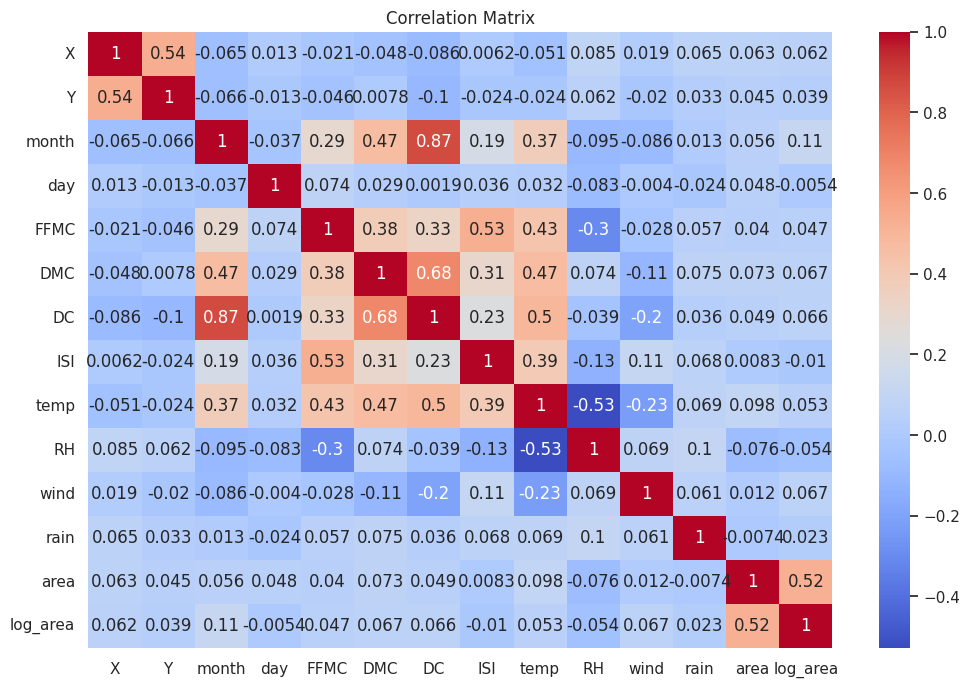

In [77]:
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [14]:
# log transformation

df['log_area'] = np.log1p(df['area'])

In [44]:
# use random forest to evaluate feature importance
model = RandomForestRegressor()
model.fit(df.drop(columns=['log_area', 'area']), df['log_area'])

feature_importances = pd.DataFrame(model.feature_importances_,
                                   index=df.drop(columns=['log_area', 'area']).columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

       importance
temp     0.186972
RH       0.124424
DMC      0.106548
wind     0.096332
X        0.087868
DC       0.087017
ISI      0.081101
Y        0.073748
FFMC     0.068643
day      0.056300
month    0.029909
rain     0.001140


In [15]:
# split data
y = df['log_area']
X = df.drop(['area', 'log_area'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training data shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing data shape: X_test: {X_test.shape}, y_test: {y_test.shape}")

Training data shape: X_train: (413, 12), y_train: (413,)
Testing data shape: X_test: (104, 12), y_test: (104,)


In [99]:
# Random Forest

rf = RandomForestRegressor(random_state=42)

# define param_grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# find best parameters
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(f"Best parameters found: {grid_search.best_params_}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   1.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   1.1s
[CV] END max_depth=10, min_sa

In [100]:
# Best parameters found: {'max_depth': 10, 
                        # 'min_samples_leaf': 4, 
                        # 'min_samples_split': 10, 
                        # 'n_estimators': 300}

# use best parameters train the model
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

y_pred = best_rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")


Mean Squared Error: 2.2191649278138246
R² Score: -0.009692764852813118


In [ ]:
# SVR

scaler = StandardScaler()

pipeline = Pipeline([
    ('scaler', scaler),
    ('svr', SVR())
])

param_grid = {
    'svr__C': [0.1, 1, 10, 100],
    'svr__gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'svr__kernel': ['rbf', 'linear', 'poly']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(f"Best parameters found: {grid_search.best_params_}")
best_svr = grid_search.best_estimator_

best_svr.fit(X_train, y_train)

y_pred = best_svr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

In [ ]:
'''
Best parameters found: {'svr__C': 1, 'svr__gamma': 1, 'svr__kernel': 'rbf'}
Mean Squared Error: 2.41596037634978
R² Score: -0.09923227498668452
'''

In [24]:
# PCA
n_components = 7

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_components))
])
# print(X_train.value_counts())
X_train_pca = pipeline.fit_transform(X_train)
X_test_pca = pipeline.transform(X_test)

print(f"Original shape: {X_train.shape}")
print(f"Transformed shape: {X_train_pca.shape}")
pca = pipeline.named_steps['pca']

explained_variance = pca.explained_variance_ratio_
print(f"Explained variance ratio of each component: {explained_variance}")

cumulative_explained_variance = np.cumsum(explained_variance)
print(f"Cumulative explained variance ratio: {cumulative_explained_variance}")

Original shape: (413, 12)
Transformed shape: (413, 7)
Explained variance ratio of each component: [0.27883467 0.13155696 0.12257495 0.10303377 0.08303789 0.07800638
 0.06239292]
Cumulative explained variance ratio: [0.27883467 0.41039163 0.53296659 0.63600036 0.71903824 0.79704462
 0.85943755]


In [31]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

model.fit(X_train_pca, y_train)

y_pred = model.predict(X_test_pca)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"R²: {r2}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

Index(['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH',
       'wind', 'rain', 'area', 'log_area'],
      dtype='object')
R²: 0.023231951886588553
MSE: 2.146800958109698
RMSE: 1.4651965595474548


In [33]:
svr = SVR(kernel='rbf', C=1, gamma=1)  
svr.fit(X_train_pca, y_train)

y_pred = svr.predict(X_test_pca)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

Mean Squared Error: 2.6379830632146124
R² Score: -0.2002498684746301


In [34]:
# our both models r2-score are too low, so we will convert it to a catrgorical value
small_threshold = 10  
large_threshold = 100  

# cut the are 
df['area_class'] = pd.cut(df['area'], bins=[-float('inf'), small_threshold, large_threshold, float('inf')],
                          labels=['small', 'medium', 'large'])
X_train, X_test, y_train, y_test = train_test_split(X, df['area_class'], test_size=0.2, random_state=42)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

       large       0.00      0.00      0.00         2
      medium       0.50      0.11      0.17        19
       small       0.81      0.98      0.89        83

    accuracy                           0.80       104
   macro avg       0.44      0.36      0.35       104
weighted avg       0.74      0.80      0.74       104

[[ 0  0  2]
 [ 0  2 17]
 [ 0  2 81]]


In [ ]:
'''
Although the overall accuracy is 80%, the model performs very poorly on the large and medium categories. 
Therefore, I have decided to adjust the class weights and reevaluate the model.
'''

In [107]:
clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

       large       0.00      0.00      0.00         2
      medium       0.67      0.11      0.18        19
       small       0.81      0.99      0.89        83

    accuracy                           0.81       104
   macro avg       0.49      0.36      0.36       104
weighted avg       0.77      0.81      0.74       104

[[ 0  0  2]
 [ 0  2 17]
 [ 0  1 82]]


In [ ]:
'''
Improved on medium , but still lack of prediction on large.
'''

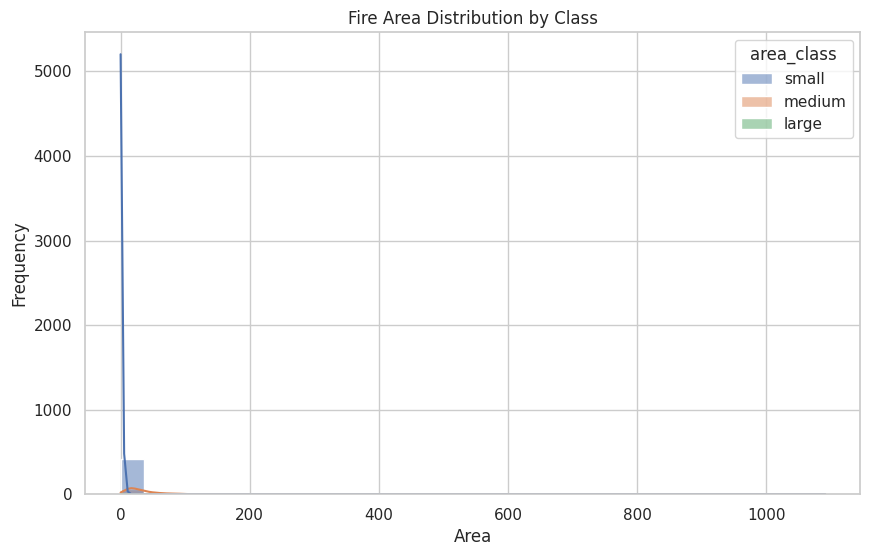

In [108]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='area', hue='area_class', kde=True, bins=30)
plt.title('Fire Area Distribution by Class')
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.show()

In [110]:
df[df['area_class']=='large'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 11 entries, 232 to 479
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   X           11 non-null     int64   
 1   Y           11 non-null     int64   
 2   month       11 non-null     category
 3   day         11 non-null     int64   
 4   FFMC        11 non-null     float64 
 5   DMC         11 non-null     float64 
 6   DC          11 non-null     float64 
 7   ISI         11 non-null     float64 
 8   temp        11 non-null     float64 
 9   RH          11 non-null     int64   
 10  wind        11 non-null     float64 
 11  rain        11 non-null     float64 
 12  area        11 non-null     float64 
 13  log_area    11 non-null     float64 
 14  area_class  11 non-null     category
dtypes: category(2), float64(9), int64(4)
memory usage: 1.7 KB


In [113]:
'''
Based on unbalanced data, decide to use SMOTE to improve sampling
'''
# oversampling
df_large = df[df['area_class'] == 'large']
df_majority = df[df['area_class'] != 'large']

df_large_upsampled = resample(df_large, 
                              replace=True,     # allow repetitively sample
                              n_samples=len(df_majority),  
                              random_state=42)  
df_upsampled = pd.concat([df_majority, df_large_upsampled])
X_upsampled = df_upsampled.drop(columns=['area_class', 'area', 'log_area'])
y_upsampled = df_upsampled['area_class']

X_train, X_test, y_train, y_test = train_test_split(X_upsampled, y_upsampled, test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       large       0.99      1.00      1.00       104
      medium       0.25      0.05      0.08        20
       small       0.80      0.95      0.87        79

    accuracy                           0.89       203
   macro avg       0.68      0.67      0.65       203
weighted avg       0.84      0.89      0.86       203



In [114]:
#undersampling
df_small = df[df['area_class'] == 'small']
df_majority_downsampled = resample(df_small, 
                                   replace=False,    # no repetitively sample
                                   n_samples=len(df[df['area_class'] != 'small']),  
                                   random_state=42)  

df_downsampled = pd.concat([df_majority_downsampled, df[df['area_class'] != 'small']])
X_downsampled = df_downsampled.drop(columns=['area_class', 'area', 'log_area'])
y_downsampled = df_downsampled['area_class']

X_train, X_test, y_train, y_test = train_test_split(X_downsampled, y_downsampled, test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      medium       0.50      0.25      0.33        20
       small       0.46      0.72      0.57        18

    accuracy                           0.47        38
   macro avg       0.48      0.49      0.45        38
weighted avg       0.48      0.47      0.44        38



In [117]:
sm = SMOTE(random_state=42)

X_resampled, y_resampled = sm.fit_resample(X, df['area_class'])

print(f"Original X shape: {X.shape}")
print(f"Resampled X shape: {X_resampled.shape}")
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Original X shape: (517, 12)
Resampled X shape: (1266, 12)
              precision    recall  f1-score   support

       large       0.95      0.99      0.97        79
      medium       0.80      0.82      0.81        90
       small       0.80      0.75      0.78        85

    accuracy                           0.85       254
   macro avg       0.85      0.85      0.85       254
weighted avg       0.85      0.85      0.85       254

[[78  0  1]
 [ 1 74 15]
 [ 3 18 64]]


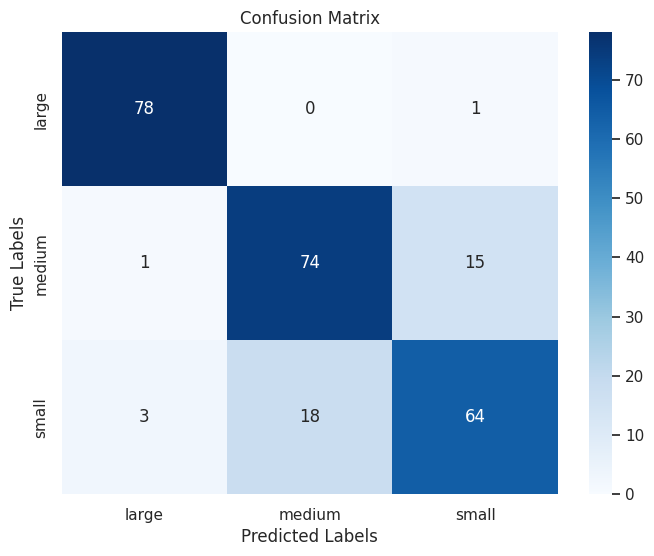

In [118]:
cm = confusion_matrix(y_test, y_pred, labels=['large', 'medium', 'small'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['large', 'medium', 'small'], yticklabels=['large', 'medium', 'small'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
'''
Report Analysis:
The model achieved an overall accuracy of 85%. 
The performance for the large class is particularly strong, with a precision of 0.95 and a recall of 0.99, resulting in an excellent F1-score of 0.97. 
The medium class shows decent performance with an F1-score of 0.81, but there is some misclassification between medium and small classes. 
The small class also performs reasonably well, though slightly lower, with an F1-score of 0.78.

Confusion Matrix Analysis:
The confusion matrix indicates that the model correctly classified 78 out of 79 large samples, with minimal misclassification. 
However, there are noticeable misclassifications between the medium and small classes, where 15 medium samples were incorrectly classified as small, and 18 small samples were classified as medium.

Conclusion:
The SMOTE technique significantly improved the model's ability to classify the large class. 
However, further refinement may be needed to improve the distinction between medium and small classes.
'''